# Praca domowa nr 2
### Wojciech Celej

## 1. Odtworzenie danych

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Przygotowanie danych

Wybrane przeze mnie zmienne to:
* ilościowe: 
    - `time_from_rel_to_cohab` -  year_fraction_first_cohab - year_fraction_relstart, negreset to zero 
    - `w6_q24_length` - length of q24 how met answer in characters 
* jakościowe: 
    - `hcm2017q24_church` - met in or through church or religious organization
    - `hcm2017q24_btwn_I_sig_other` - significant other relationship  between intermediaries

In [3]:
myDf = df.loc[:, ["time_from_rel_to_cohab", "w6_q24_length", "hcm2017q24_church", "hcm2017q24_btwn_I_sig_other", "S1"]].dropna()
myDf = myDf.query("time_from_rel_to_cohab > 0")

In [4]:
myDf.loc[:,"hcm2017q24_church"] = myDf.loc[:,"hcm2017q24_church"].map({"yes": 1, "no": 0})
myDf.loc[:,"hcm2017q24_btwn_I_sig_other"] = myDf.loc[:,"hcm2017q24_btwn_I_sig_other"].map({"yes": 1, "no": 0})
myDf.loc[:,"S1"] = myDf.loc[:,"S1"].apply(lambda x: 1 if x.startswith("Yes") else 0).astype(np.int32)

In [5]:
myDf.describe()

,time_from_rel_to_cohab,w6_q24_length,hcm2017q24_church,hcm2017q24_btwn_I_sig_other,S1
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,2.062340,200.837784,0.063417,0.015531,0.768335
std,2.775629,253.214661,0.243764,0.123677,0.421987
min,0.083252,1.000000,0.000000,0.000000,0.000000
25%,0.500000,67.000000,0.000000,0.000000,1.000000
50%,1.166748,136.000000,0.000000,0.000000,1.000000
75%,2.583252,241.000000,0.000000,0.000000,1.000000
max,36.750000,3855.000000,1.000000,1.000000,1.000000


### Klasyfikator: XGBoost

In [9]:
import xgboost
import sklearn.model_selection
import sklearn.metrics

In [10]:
xgbModel = xgboost.XGBClassifier()
X = myDf.iloc[:, :4]
Y = myDf.loc[:, "S1"]
cv_scores = sklearn.model_selection.cross_validate(xgbModel, X, Y, cv = 10)

In [11]:
xgbModel.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [12]:
cv_scores["test_score"].mean()

0.7627211831629472

## 2. Wykresy PDP  i ALE

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,12)})
sns.set_style("darkgrid")
sns.set_context("paper")

In [14]:
def plot_dp(model, df, feature, nPoints, ax):
    featureRange = (df.loc[:, feature].min(), df.loc[:, feature].max())
    x = np.linspace(featureRange[0], featureRange[1], num=nPoints, endpoint=True)
    y_cum = []
    for index, row in df.iterrows():
        sample = pd.DataFrame(columns=row.index)
        sample.loc[0] = row.values
        samples = sample.append([sample.iloc[0, :]]*(nPoints-1), ignore_index=True).reset_index(drop=True)
        samples.loc[:, feature] = x
        y = model.predict_proba(samples)[:,1]
        y_cum.append(y)
        ax.plot(x, y, color="gray", linewidth=0.5, alpha = 0.4)
        sample_x = sample.loc[:, feature]
        sample_prob = model.predict_proba(sample)[:,1]
        ax.plot(sample_x, sample_prob, "o", markersize=3, color="black", alpha=0.6)
    y_cum = np.array(y_cum).mean(axis=0)
    ax.plot(x, y_cum, color="navy", linewidth=5)
    ax.set_ylabel("Married probability")
    ax.set_ylim(0,1)
    ax.set_title("PDP")
    return x, y_cum

In [15]:
def plot_ale(model, df, feature, ax):
    quantile = df[feature].quantile(np.linspace(0.005, 1, 200))
    x_vect = []
    y_vect = []
    
    prev_x = df[feature].min()
    next_x = quantile.iloc[0]
    samples = df.loc[(df[feature] >= prev_x) & (df[feature] <= next_x)]
    n_samples = samples.shape[0]
    y_upper = 0
    y_bottom = 0
    for index, row in samples.iterrows():
        sample = pd.DataFrame(columns=row.index)
        sample.loc[0] = row.values
        sample.loc[1] = row.values
        sample.loc[0, feature] = prev_x
        sample.loc[1, feature] = next_x
        y = model.predict_proba(sample)[:,1]
        y_upper += y[1]
        y_bottom += y[0]
    if n_samples > 0:
        acc_effect = (y_upper - y_bottom) / n_samples
    else:
        acc_effect = 0
    x_value = (prev_x + next_x) / 2
    x_vect.append(x_value)
    y_vect.append(acc_effect)
    prev_x = next_x

    for next_x in quantile.iloc[1:]:
        samples = df.loc[(df[feature] > prev_x) & (df[feature] <= next_x)]
        n_samples = samples.shape[0]
        if n_samples == 0:
            continue
        y_upper = 0
        y_bottom = 0
        for index, row in samples.iterrows():
            sample = pd.DataFrame(columns=row.index)
            sample.loc[0] = row.values
            sample.loc[1] = row.values
            sample.loc[0, feature] = prev_x
            sample.loc[1, feature] = next_x
            y = model.predict_proba(sample)[:,1]
            y_upper += y[1]
            y_bottom += y[0]
        acc_effect = (y_upper - y_bottom) / n_samples       
        x_value = (prev_x + next_x) / 2
        x_vect.append(x_value)
        y_vect.append(acc_effect)
        prev_x = next_x

    x_vect = np.array(x_vect)
    y_vect = np.array(y_vect)
    y_vect = y_vect.cumsum()
    y_vect = y_vect - y_vect.mean()
    ax.plot(x_vect, y_vect, color="darkred")
    ax.set_title("ALE plot")
    ax.set_ylabel("ALE values")
    return x_vect, y_vect

In [16]:
def compare_plots(model, X, feature):
    fig, axes = plt.subplots(2, 1)
    plot_dp(model, X, feature, 100, axes[0])
    plot_ale(model, X, feature, axes[1])
    axes[0].set_xlim(axes[1].get_xlim())
    axes[1].set_xlabel(feature)

### Pierwsza zmienna

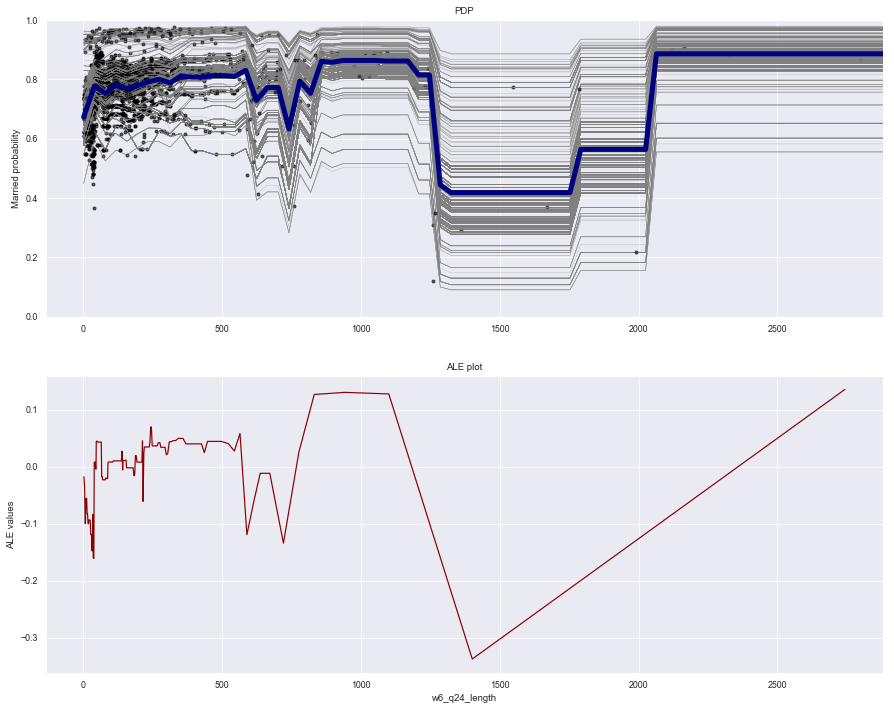

In [17]:
compare_plots(xgbModel, X, "w6_q24_length")

### Druga zmienna

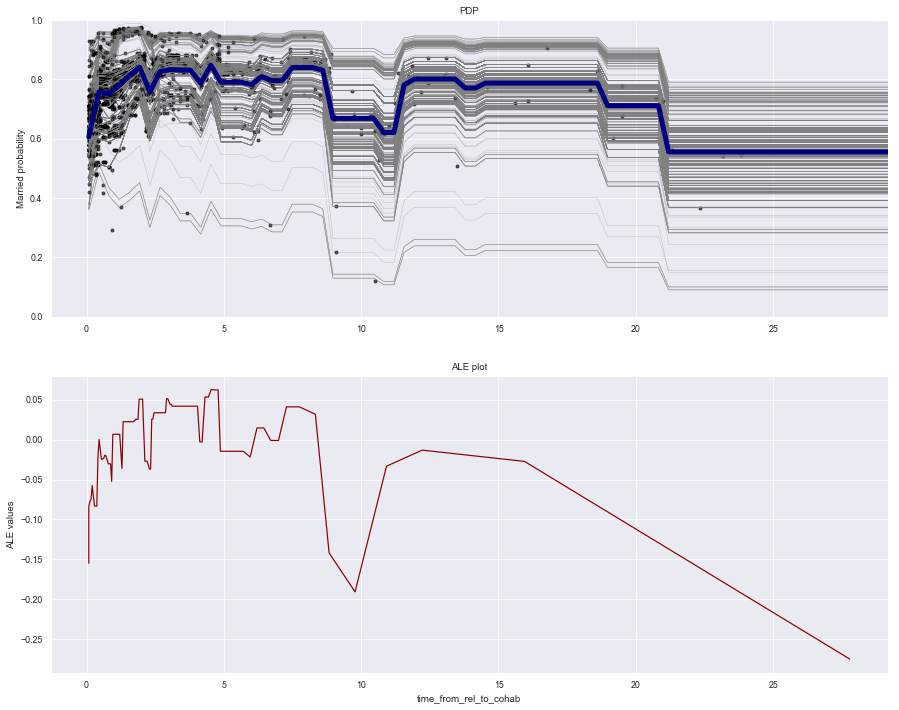

In [18]:
compare_plots(xgbModel, X, "time_from_rel_to_cohab")

In [19]:
X.loc[:, ["w6_q24_length", "time_from_rel_to_cohab"]].corr()

,w6_q24_length,time_from_rel_to_cohab
w6_q24_length,1.000000,-0.007784
time_from_rel_to_cohab,-0.007784,1.000000


## 3. Wnioski

* Wykresy PDP i ALE w miejscach koncentracji próbek uzyskują podobne kształty  
* Wykres ALE generwoano w kwantylach co 0.005, ostanie kwantyle obejmowały znaczny zakres x, przez co próbkowanie wartości ALE jest zagęszczone dla mniejszych $x$
* Użyto kwantyli pot to aby uśrednianie w przedziałach następowało dla takiej samej liczby próbek, innym podejściem mogłoby być liczenie przyrostów w stałych przedziałach
* Wybrane parametry, dla których budowano model, nie są zależne, stąd wykresy PD i ALE w podobny sposób wyjaśniają model
* Dla zmiennej `w6_q24_length` wykres ALE różni się trendem od wykresu PDP dla początkowych $x$ i $x$ w okolicy $[1200, 2000]$
* Częstotliwość próbkowania wykresu PDP jest nieograniczona, w przypadku wykresu ALE próbkowanie zależy od liczności próby i doboru przedziałów
* Dla wybranych zmiennych oba wykresy mogą zostać użyte do objaśniania modelu